# Table of Content

1) Importing Libraries

2) Get the Data

3) Clean the Data

4) Categorical Analysis

5) Numerical Analysis

6) Conclusion

7) Feature Engineering 

8) Feature Selection and Feature Importance 

9) Preprocessing for ML Models

10) Creating Models and Evaluating 


## Import Libraries

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,FunctionTransformer
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,GridSearchCV,learning_curve,RandomizedSearchCV

from sklearn.linear_model import SGDRegressor,Ridge,ElasticNet,RidgeCV,ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Get the Data

In [2]:
housing=pd.read_csv('/kaggle/input/california-housing-prices/housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## cleaning the Data

In [4]:
#First let's check the null values
housing_copy=housing.copy()
housing_copy.isnull().sum().sort_values(ascending=False)

total_bedrooms        207
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

**total_bedrooms** contains null values wich I choose to handle it using knnimputer

In [5]:
knn_imputer = KNNImputer(n_neighbors=5)
housing_copy['total_bedrooms']=knn_imputer.fit_transform(housing_copy[['total_bedrooms']])


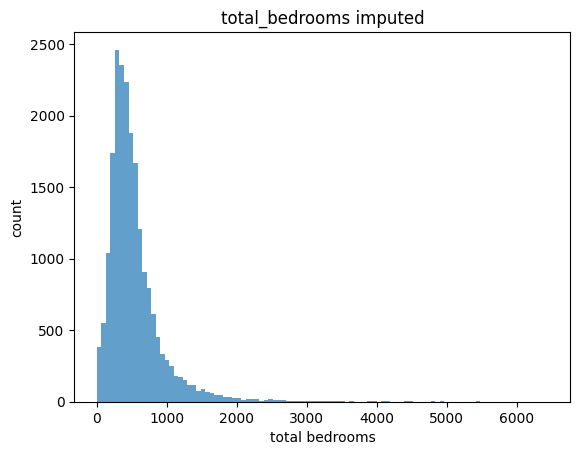

In [6]:
plt.hist(housing_copy['total_bedrooms'],bins=100,alpha=0.7)
plt.title('total_bedrooms imputed')
plt.xlabel('total bedrooms')
plt.ylabel('count')
plt.show()

In [7]:
#Checking the duplicated values
housing_copy.duplicated().sum()

0

## Categorical Analysis

In [8]:
#Let's seperate the categorical features from others

cat_features=[feature for feature in housing_copy.columns if housing_copy[feature].dtypes==object]
cat_features

['ocean_proximity']

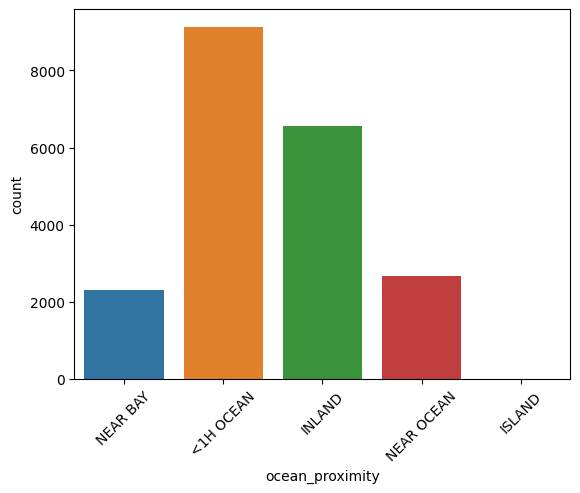

In [9]:
sns.countplot(data=housing_copy, x="ocean_proximity")
plt.xticks(rotation=45)
plt.show()

The moset frequent **ocean_proximity** is <1H OCEAN and it means most of the district are in that distance with the ocean

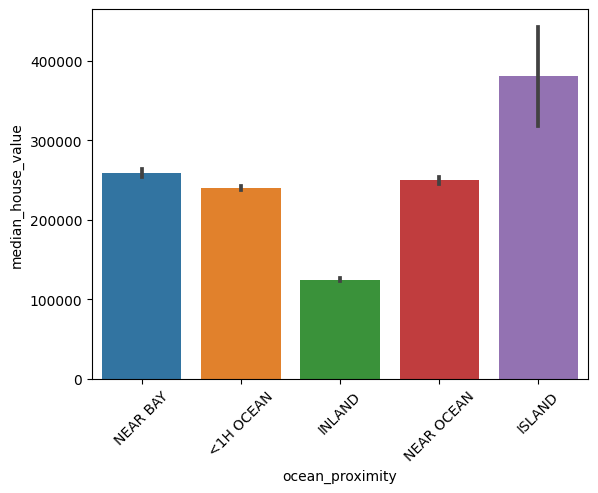

In [10]:
sns.barplot(data=housing_copy, x="ocean_proximity", y="median_house_value")
plt.xticks(rotation=45)
plt.show()

Districts in the **ISLAND** has higher median house value comparing to others.

## Numerical Analysis

In [11]:
#First we go for discrete values
discrite_featuers=['total_bedrooms','total_rooms','households','housing_median_age']

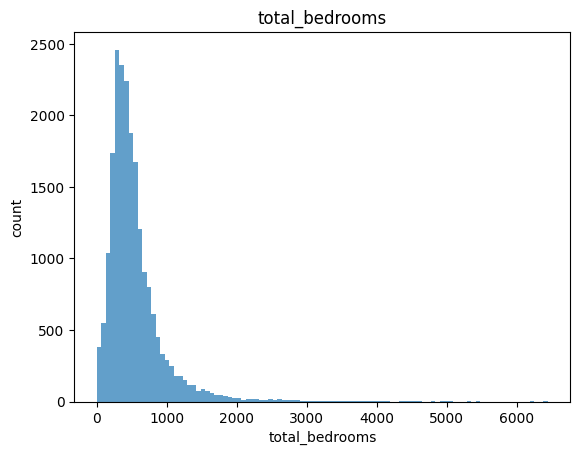

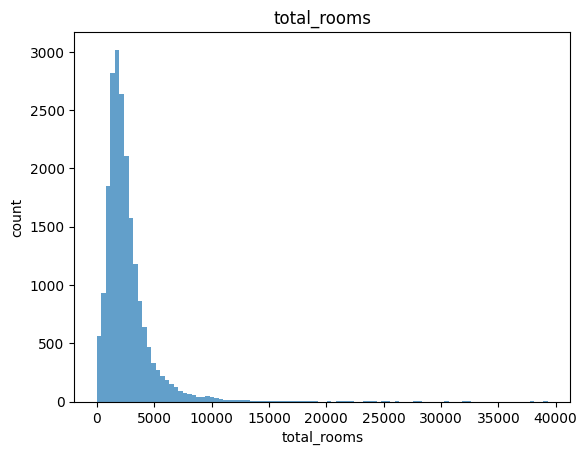

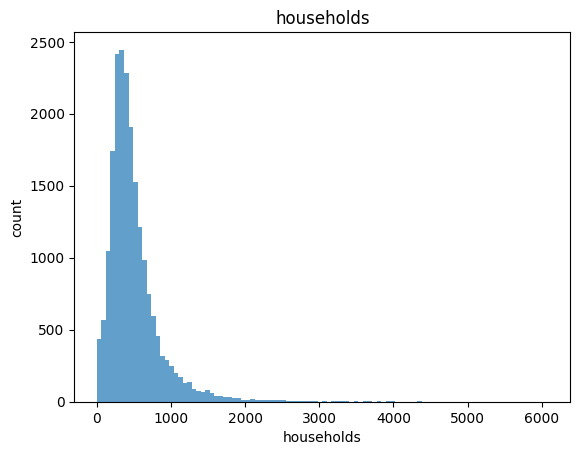

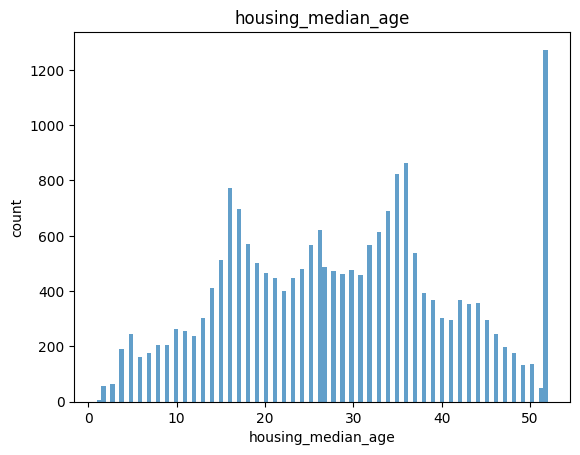

In [12]:
for i in discrite_featuers:
    plt.figure()
    plt.hist(housing_copy[i], bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

In [13]:
#Let's check the skewness of the data
for i in discrite_featuers:
    print(f'{i} skewness: {np.round(housing_copy[i].skew(),4)}')

total_bedrooms skewness: 3.477
total_rooms skewness: 4.1473
households skewness: 3.4104
housing_median_age skewness: 0.0603


- The first problem I see is that the **housing_median_age** is caped at the end.Probabely houses older than that where caped at the end and it's not good

- Other columns are clearlly skewed to the right

In [14]:
#Let's check the number of outliers in each feature
#function to detect outlayers
def outlayer_detection(x):
    outlayers=[]
    q1=np.quantile(x,0.25)
    q3=np.quantile(x,0.75)
    iqr=q3-q1
    
    lower_bound=q1-1.5*iqr
    upper_bound=q3+1.5*iqr
    for i in x:
        if i<lower_bound or i>upper_bound:
            outlayers.append(i)
    return outlayers

In [15]:
#check the number of outliers before implementing log1p
print('Befor implementing log1p:')
for i in discrite_featuers:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')

Befor implementing log1p:
 total_bedrooms: 1306
 total_rooms: 1287
 households: 1220
 housing_median_age: 0


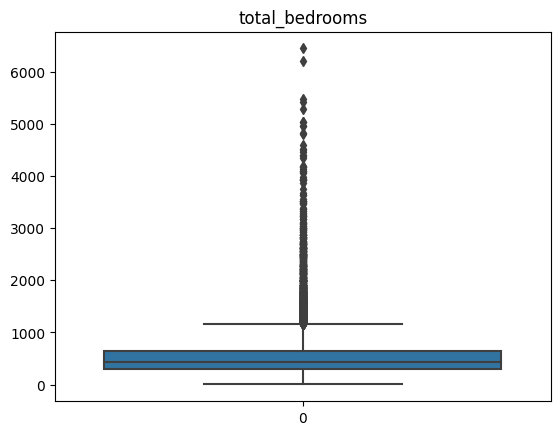

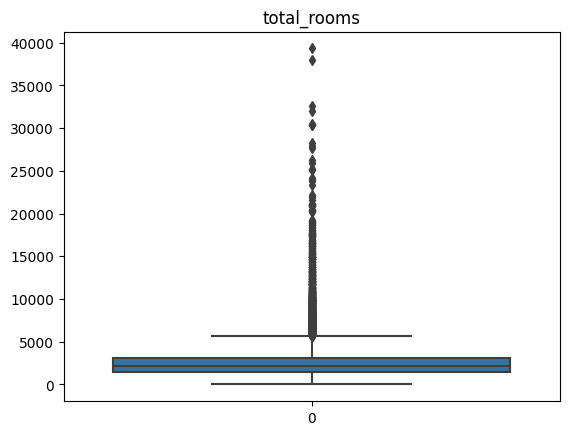

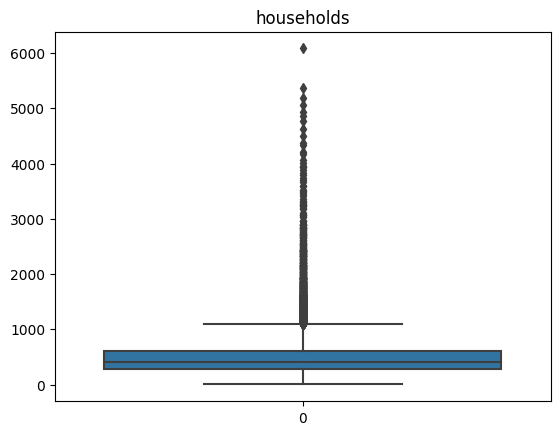

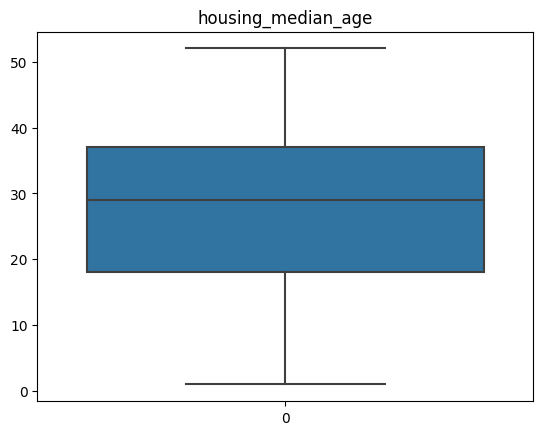

In [16]:
#Visualizing outliers using boxplot
for i in discrite_featuers:
    plt.figure()
    sns.boxplot(housing_copy[i])
    plt.title(i)
    plt.show()

Data has significant number of outliers so I try to limit them using log1p

In [17]:
#Since most of features are skewed to the write i think using log could be a good choice
discrite_featuers_new=discrite_featuers[:-1]
housing_copy[discrite_featuers_new]=np.log1p(housing_copy[discrite_featuers_new])

#For median_house_age wich is not skewed standardscaller is better
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
housing_copy['housing_median_age']=scaler.fit_transform(housing_copy[['housing_median_age']])

In [18]:
#Let's check the skewness after implementing log1p
for i in discrite_featuers:
    print(f'{i} skewness:{housing_copy[i].skew()}')

total_bedrooms skewness:-1.0056862385367007
total_rooms skewness:-1.0755326843333568
households skewness:-1.0516074281263579
housing_median_age skewness:0.06033063759913685


The data is still moderatlly skewed but it's better

In [19]:
print('After implementing log1p:')
for i in discrite_featuers:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')
     

After implementing log1p:
 total_bedrooms: 836
 total_rooms: 957
 households: 882
 housing_median_age: 0


- **toal_bedrooms** outliers droped obout: 470
- **total_rooms** outliers droped obout: 330
- **households** outliers droped about: 338

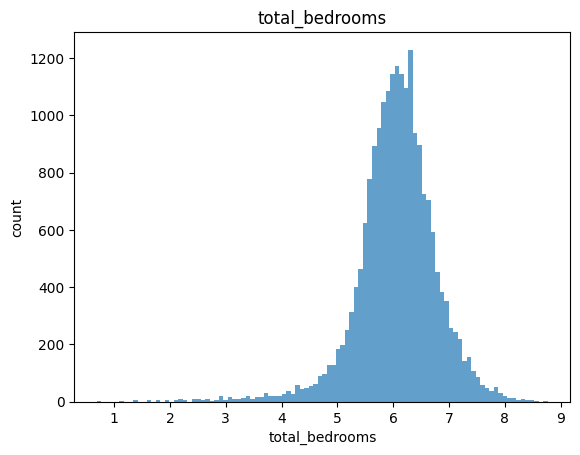

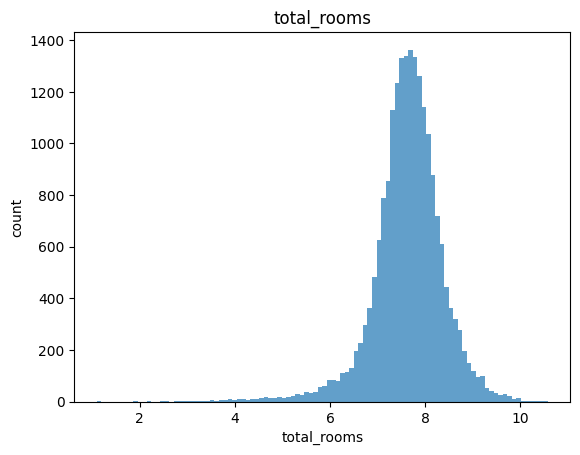

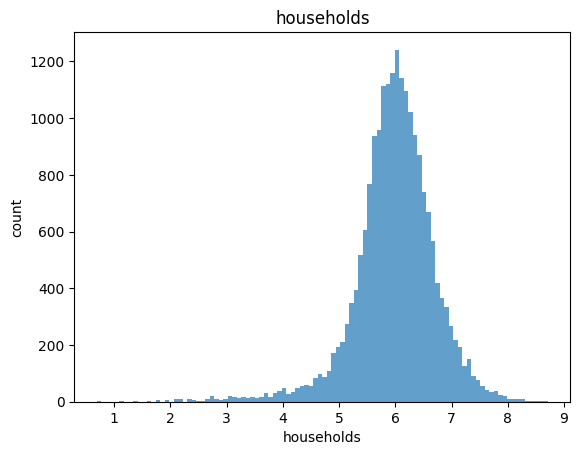

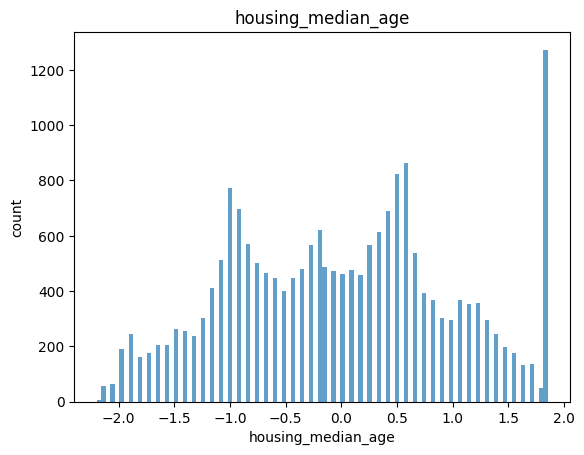

In [20]:
#Let's see the data after implementing log1p
for i in discrite_featuers:
    plt.figure()
    plt.hist(housing_copy[i], bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

#Continuous features

In [21]:
#Continuous features
continuous_features=['longitude','latitude','median_income','median_house_value']

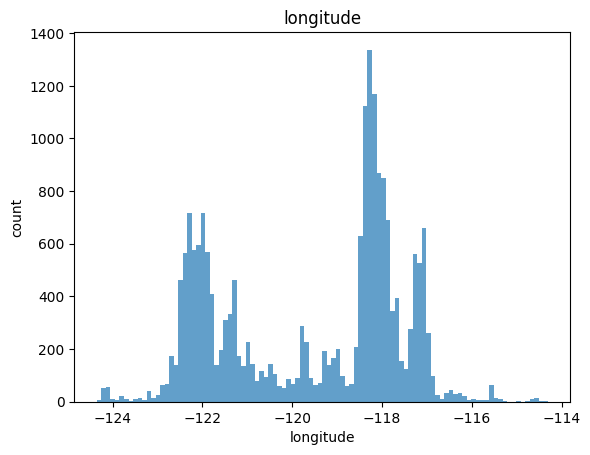

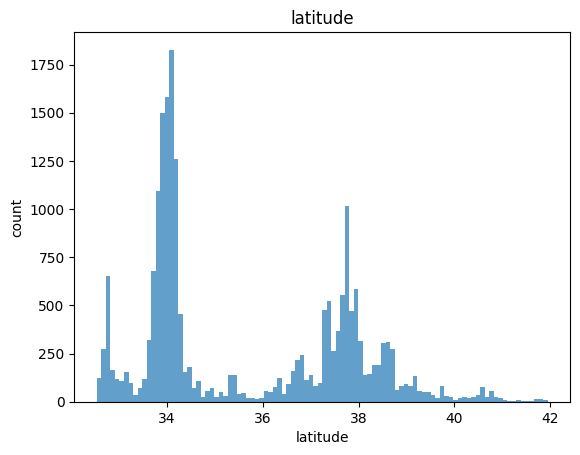

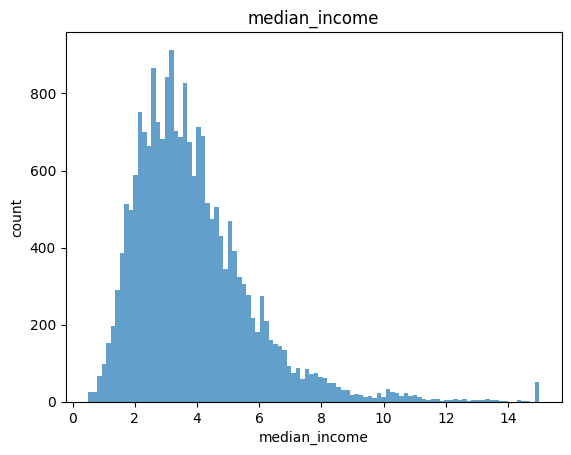

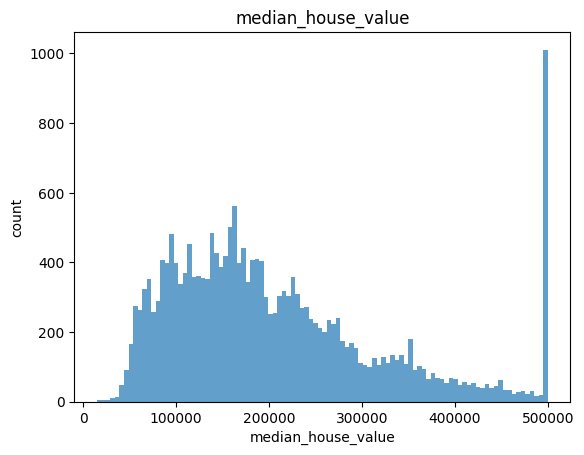

In [22]:
for i in continuous_features:
    plt.figure()
    plt.hist(housing[i],bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

In [23]:
#Let's check the skewness of the data
for i in continuous_features:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')
     

 longitude: 0
 latitude: 0
 median_income: 681
 median_house_value: 1071


- both **longitude** and **latitude** has irregulare shape wich needs to be handled

- **median_income** is skewed to the right

- **median_house_value** wich the the target variable is caped at the 500000 and it's a problem and it is skewed too.

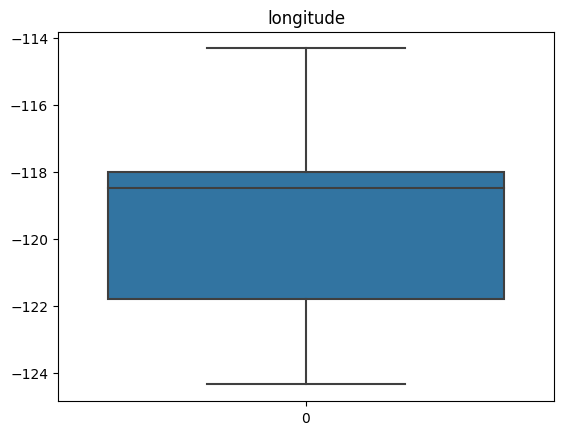

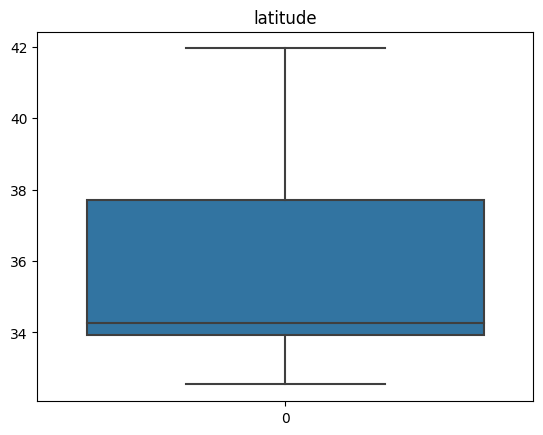

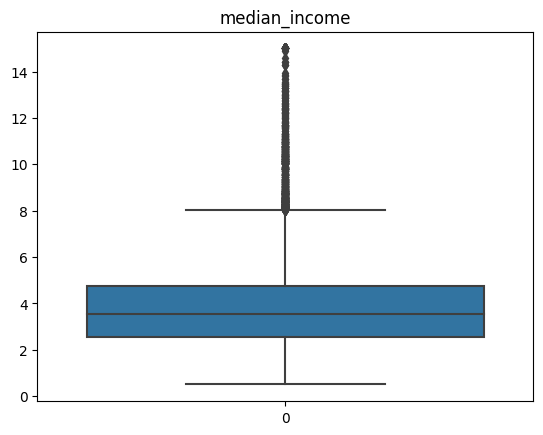

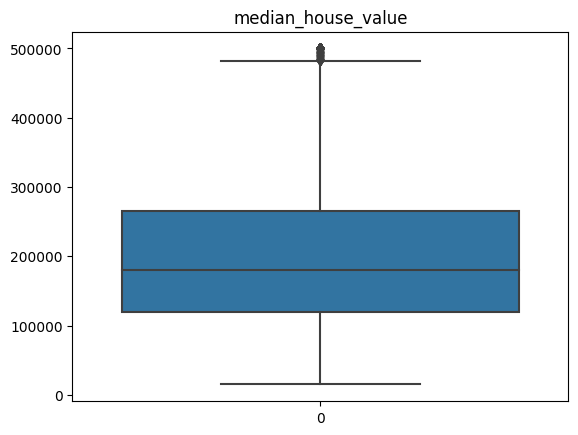

In [24]:
#let's check the outliers visualy
for i in continuous_features:
    plt.figure()
    sns.boxplot(housing[i])
    plt.title(i)
    plt.show()

In [25]:
for i in continuous_features:
    print(f'{i} skewness: {housing[i].skew()}')

longitude skewness: -0.2978012079524363
latitude skewness: 0.46595300370997
median_income skewness: 1.6466567021344465
median_house_value skewness: 0.9777632739098342


- The **median_income** has a noticable outliers.

- **median_house_value** has outliers too.

In [26]:
#Longitude and Latitude just need to be scaled
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
housing_copy[['longitude','latitude']]=min_max.fit_transform(housing_copy[['longitude','latitude']])

#Median_income and median_house_value are skewed to the right so we can use log1p
housing_copy['median_income']=np.log1p(housing_copy['median_income'])

#We live median_house_value as the label alone for know
#But we know wich it isn hase been scaled before because of the range of values and thy don't look like house prices in dolors

In [27]:
print('After implementing log1p:')
for i in continuous_features:
    print(f' {i}: {len(outlayer_detection(housing_copy[i]))}')
     

After implementing log1p:
 longitude: 0
 latitude: 0
 median_income: 226
 median_house_value: 1071


- **median_income** outliers droped about: 455

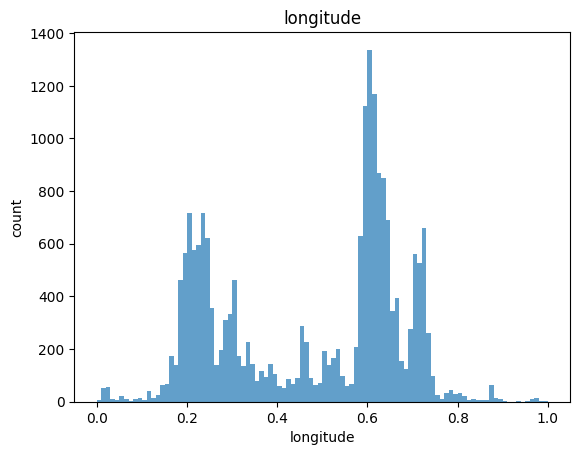

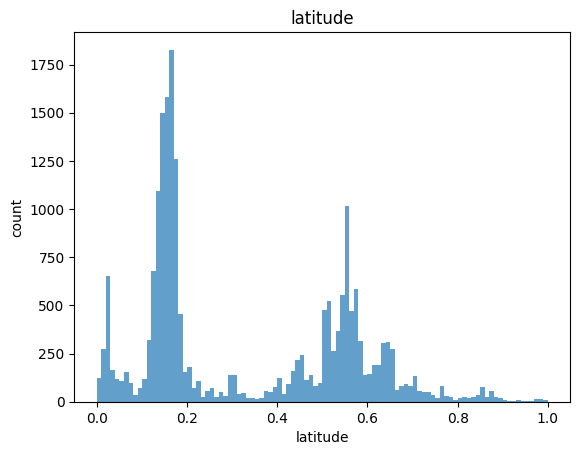

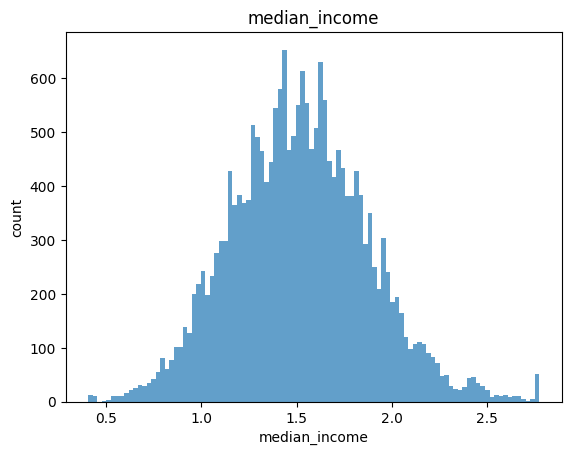

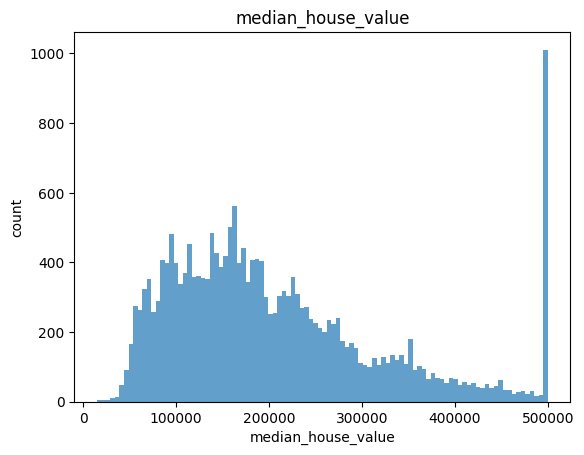

In [28]:
#let's watch the continuous data after scalling

for i in continuous_features:
    plt.figure()
    plt.hist(housing_copy[i],bins=100,alpha=0.7)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('count')
    plt.show()

In [29]:
for i in continuous_features:
    print(f'{i} skewness: {housing_copy[i].skew()}')

longitude skewness: -0.2978012079524091
latitude skewness: 0.4659530037099733
median_income skewness: 0.22608313067130542
median_house_value skewness: 0.9777632739098342


- Since we implemented the log1p just for **median_income** other columns remain unchanged, but the **median_income** skewness decreased a lot.

## Conclusion

- Despite all the scalling and transformatoing the data still has outliers and skewness in it and needs to be tweked more

- Binning and creating simillarity features for some columns like **housing_median_age** and **longitued,lattitued** can be helpfull.

- Sadly at some columns like **median_house_value** and others we saw the data being caped at some point wich is not good and we can't fix it because it needs domain knowledge and data

## Feature Engineering

In [30]:
#I found below combinations helpfull
housing_copy['bedrooms_ratio']=housing_copy['total_bedrooms']/housing_copy['total_rooms']
housing_copy['rooms_per_house']=housing_copy['total_rooms']/housing_copy['households']
housing_copy['income_population_ratio']=housing_copy['median_income']/housing_copy['population']

## Feature Selection and Feature Importance

correlation:

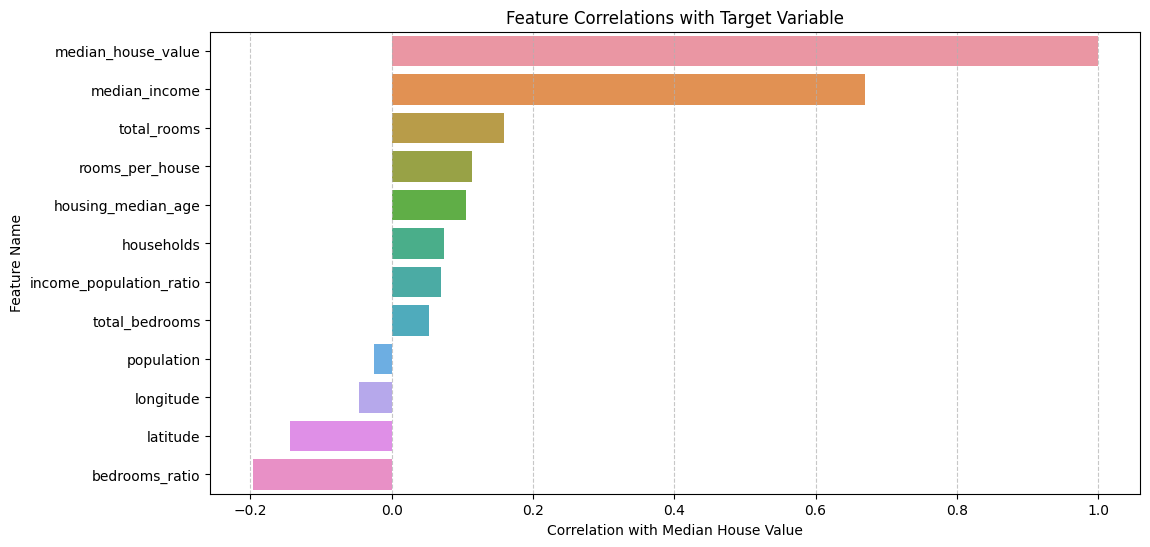

In [31]:
#computing the correlations between features and the label
housing_corr = housing_copy.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=housing_corr.index, x=housing_corr.values)

plt.xlabel('Correlation with Median House Value')
plt.ylabel('Feature Name')
plt.title('Feature Correlations with Target Variable')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


Anova-test:

In [32]:
#Calculating numerical features importance using Anova-test
numerical_features=discrite_featuers+continuous_features+['bedrooms_ratio','rooms_per_house','income_population_ratio']

X = housing_copy[numerical_features].drop(columns='median_house_value')
y = housing_copy['median_house_value']  

anova_selector = SelectKBest(score_func=f_regression, k='all')  
X_selected = anova_selector.fit_transform(X, y)

scores = anova_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'ANOVA Score': scores})
print(feature_scores.sort_values(by='ANOVA Score', ascending=False))

                   Feature   ANOVA Score
6            median_income  16802.949938
7           bedrooms_ratio    831.597767
1              total_rooms    538.199930
5                 latitude    438.005453
8          rooms_per_house    271.718228
3       housing_median_age    232.841479
2               households    112.441167
9  income_population_ratio    103.049281
0           total_bedrooms     58.157072
4                longitude     43.698976


Using Random Forest to detect feature's importance:

In [33]:
#Computing numerical feature's importance using randomforest
X = housing_copy[numerical_features].drop(columns='median_house_value')
y = housing_copy['median_house_value']  

rnd_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rnd_reg.fit(X, y)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rnd_reg.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

perm_importance = permutation_importance(rnd_reg, X, y, scoring='neg_mean_absolute_error')

perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

perm_importance_df


,Feature,Importance
6,median_income,65408.405743
5,latitude,58266.377173
4,longitude,57259.298807
3,housing_median_age,17109.243759
7,bedrooms_ratio,13556.684422
9,income_population_ratio,12342.024394
8,rooms_per_house,8592.625359
1,total_rooms,6472.959878
0,total_bedrooms,3941.122600
2,households,3577.338308


<h3>Feature engineering and Tests conclusion:</h3>

- Some Combinations of features where added to the dataset

- Accourding to the tests It is better to ignore **households**

- Note that we have used **households** in the combinations we created wich had better test scores, and with regard to  it's low test score it's better to ignore it.

## Preprocessing for ML Models

In [34]:
#Since median_income has a huge impact on the model decisions so we stratify the X and y based on median_income
housing['income_cat']=pd.cut(housing['median_income'],bins=[0,1.5,3,4.5,6,np.inf],labels=[1,2,3,4,5])

In [35]:
#Before any further actino we need to split the data 

X=housing.drop(columns=['median_house_value'])
y=housing['median_house_value'].copy()


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=housing['income_cat'],random_state=42)

X_train.drop(columns=['income_cat'],inplace=True)
X_test.drop(columns=['income_cat'],inplace=True)


In [36]:
#Let's make the preprocessing pipeline

standard_features = ['housing_median_age','longitude']
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
log_features=['total_bedrooms','total_rooms','latitude','median_income']#,'households'
cat_pipe=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)


log_pipe=make_pipeline(
    KNNImputer(n_neighbors=5),
    FunctionTransformer(np.log1p,feature_names_out='one-to-one')
)

numeric_pipe=make_pipeline(
    KNNImputer(n_neighbors=5),
    StandardScaler()
)

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  

def ratio_pipeline():
    return make_pipeline(
        KNNImputer(n_neighbors=5),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

preprocessor = ColumnTransformer(
    [
        ('cat', cat_pipe, categorical_features),
        ('log', log_pipe, log_features),
        ('std', numeric_pipe,standard_features),
        ('bedrooms', ratio_pipeline(), ['total_bedrooms','total_rooms']),
        ('rooms_per_house', ratio_pipeline(), ['total_rooms','households']),
        ('income_population', ratio_pipeline(), ['median_income','population'])
    ],remainder='drop'
)
X_preprocessed=preprocessor.fit_transform(X_train)
X_preprocessed_df=pd.DataFrame(X_preprocessed,columns=preprocessor.get_feature_names_out(),index=X_train.index)


In [37]:
X_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cat__ocean_proximity_<1H OCEAN   16512 non-null  float64
 1   cat__ocean_proximity_INLAND      16512 non-null  float64
 2   cat__ocean_proximity_ISLAND      16512 non-null  float64
 3   cat__ocean_proximity_NEAR BAY    16512 non-null  float64
 4   cat__ocean_proximity_NEAR OCEAN  16512 non-null  float64
 5   log__total_bedrooms              16512 non-null  float64
 6   log__total_rooms                 16512 non-null  float64
 7   log__latitude                    16512 non-null  float64
 8   log__median_income               16512 non-null  float64
 9   std__housing_median_age          16512 non-null  float64
 10  std__longitude                   16512 non-null  float64
 11  bedrooms__ratio                  16512 non-null  float64
 12  rooms_per_house__ra

## Creating Models and Evaluating

In [38]:
#SGDRegressor
sgd_reg=make_pipeline(
    preprocessor,
    SGDRegressor(random_state=42)
)

#sgd_reg tuning
param_grid = {
    'sgdregressor__alpha': [0.00001,0.0001, 0.001, 0.01, 0.1],
    'sgdregressor__max_iter': [1000, 2000, 3000],
}

grid_search = GridSearchCV(sgd_reg, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best score: {-grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best score: 73834.57368320833
Best parameters: {'sgdregressor__alpha': 0.0001, 'sgdregressor__max_iter': 1000}


In [39]:
sgd_reg.set_params(**grid_search.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('log',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-...
                                                  ['total_rooms',
                                                   'households']),
                                                 ('income_population',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7d58515d5ea0>,
                                                                                       func=<function column_ratio at 0x7d58515d5c60>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['median_income',
                                                   'population'])])),
                ('sgdregressor', SGDRegressor(random_state=42))])

In [40]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    sgd_reg, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 40)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)


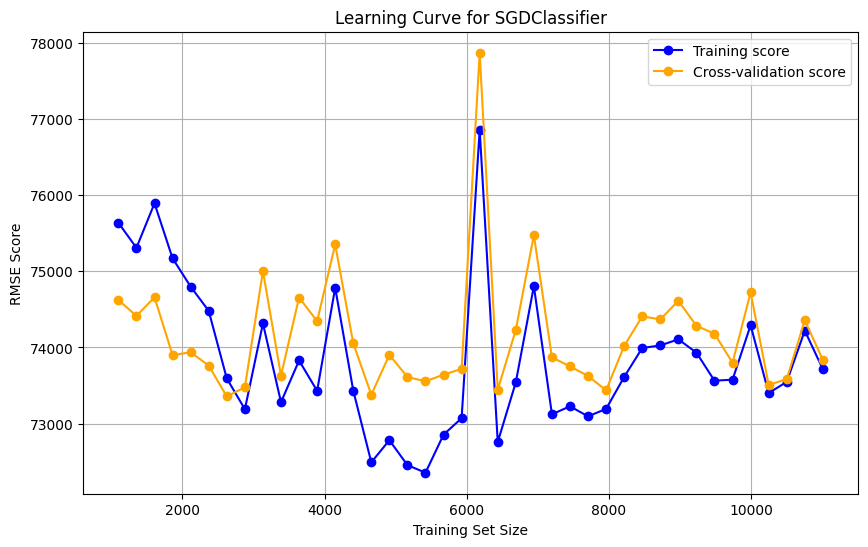

In [41]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for SGDClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid()
plt.show()

In [42]:
ridge_reg=make_pipeline(
    preprocessor,
    Ridge()
)


#Tuning the ridge_reg 
alphas = [0.01, 0.1, 1, 10, 100]

ridge_cv = RidgeCV(alphas=alphas, cv=3)

ridge_cv.fit(X_preprocessed, y_train)

print(f"Best score: {ridge_cv.best_score_}")

Best score: 0.607765682974308


In [43]:
ridge_reg.set_params(ridge__alpha=ridge_cv.alpha_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('log',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-...
                                                                   StandardScaler())]),
                                                  ['total_rooms',
                                                   'households']),
                                                 ('income_population',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7d58515d5ea0>,
                                                                                       func=<function column_ratio at 0x7d58515d5c60>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['median_income',
                                                   'population'])])),
                ('ridge', Ridge(alpha=0.1))])

In [44]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    ridge_reg, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 40)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)


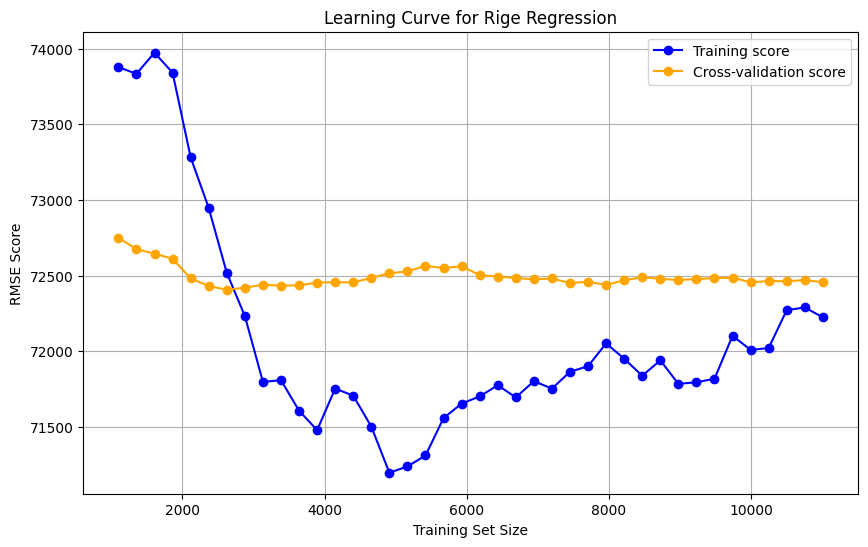

In [45]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Rige Regression')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid()
plt.show()

In [46]:
#Creating knn_reg
knn_reg=make_pipeline(
    preprocessor,
    KNeighborsRegressor()
)

param_grid = {
    'kneighborsregressor__n_neighbors': [3, 5, 10, 15],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(knn_reg, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print("Best score:", -grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best score: 64812.29945903423


In [47]:
knn_reg.set_params(**grid_search.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('log',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-...
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7d58515d5ea0>,
                                                                                       func=<function column_ratio at 0x7d58515d5c60>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['median_income',
                                                   'population'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=10,
                                     weights='distance'))])

In [48]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    knn_reg, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 40)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)


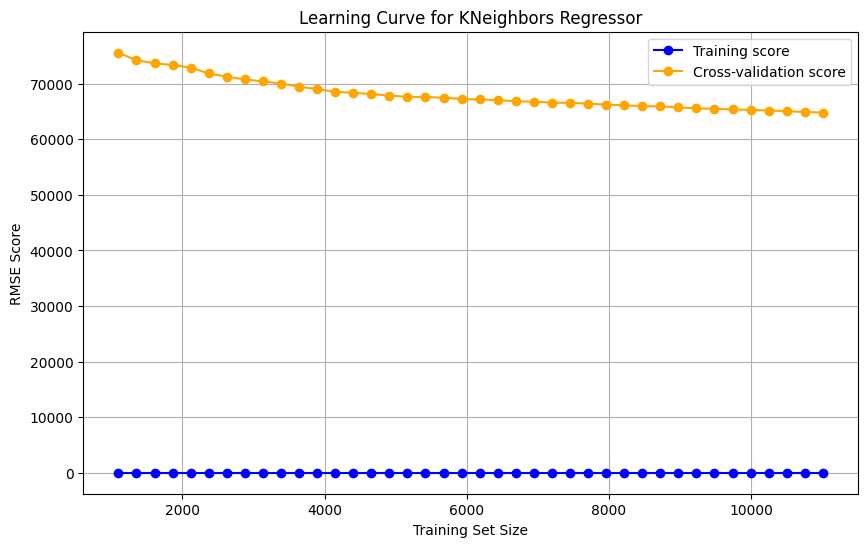

In [49]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for KNeighbors Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid()
plt.show()

In [50]:
#Creating SVR model
svr_reg=make_pipeline(
    preprocessor,
    SVR()
)

#Tune the SVR
param_dist = {
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.1, 0.5],
    'svr__kernel': ['rbf'],
    'svr__gamma': ['scale', 'auto'], 
}

random_search = RandomizedSearchCV(svr_reg, param_distributions=param_dist, cv=3, scoring='neg_root_mean_squared_error', n_iter=10, n_jobs=-1,verbose=1)
random_search.fit(X_train, y_train)

print("Best score_:", -random_search.best_score_)
print("Best params_:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score_: 105834.53918393166
Best params_: {'svr__kernel': 'rbf', 'svr__gamma': 'auto', 'svr__epsilon': 0.1, 'svr__C': 100}


In [51]:
svr_reg.set_params(**random_search.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('log',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-...
                                                                   StandardScaler())]),
                                                  ['total_rooms',
                                                   'households']),
                                                 ('income_population',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7d58515d5ea0>,
                                                                                       func=<function column_ratio at 0x7d58515d5c60>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['median_income',
                                                   'population'])])),
                ('svr', SVR(C=100, gamma='auto'))])

In [52]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    svr_reg, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 40)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)


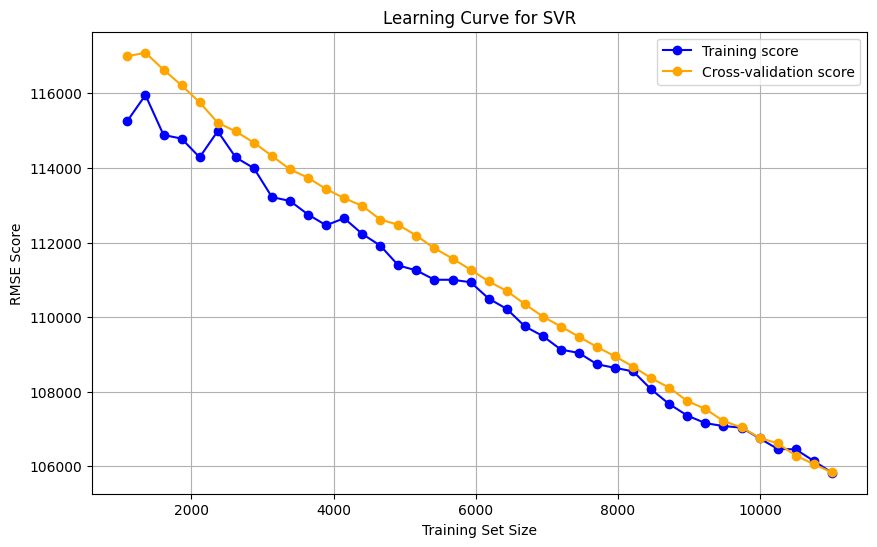

In [53]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for SVR')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid()
plt.show()

In [54]:
#Creating DecisionTreeRegressor
dt_reg=make_pipeline(
    preprocessor,
    DecisionTreeRegressor(random_state=42)
)

#Tune the DecisionTreeRegressor
param_dist = {
    'decisiontreeregressor__max_depth': [5, 10, 20, 30],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 5],
}

# Perform random search
random_search_tree = RandomizedSearchCV(dt_reg, param_distributions=param_dist, cv=3, scoring='neg_root_mean_squared_error', n_iter=10, n_jobs=-1)
random_search_tree.fit(X_train,y_train )

print(f'random_search_tree best score: {-random_search_tree.best_score_}')
print(f'random_search_tree best params: {random_search_tree.best_params_}')

random_search_tree best score: 63785.628081707015
random_search_tree best params: {'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__max_depth': 10}


In [55]:
dt_reg.set_params(**random_search_tree.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('log',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-...
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7d58515d5ea0>,
                                                                                       func=<function column_ratio at 0x7d58515d5c60>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['median_income',
                                                   'population'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=10, min_samples_leaf=2,
                                       random_state=42))])

In [56]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    dt_reg, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 40)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

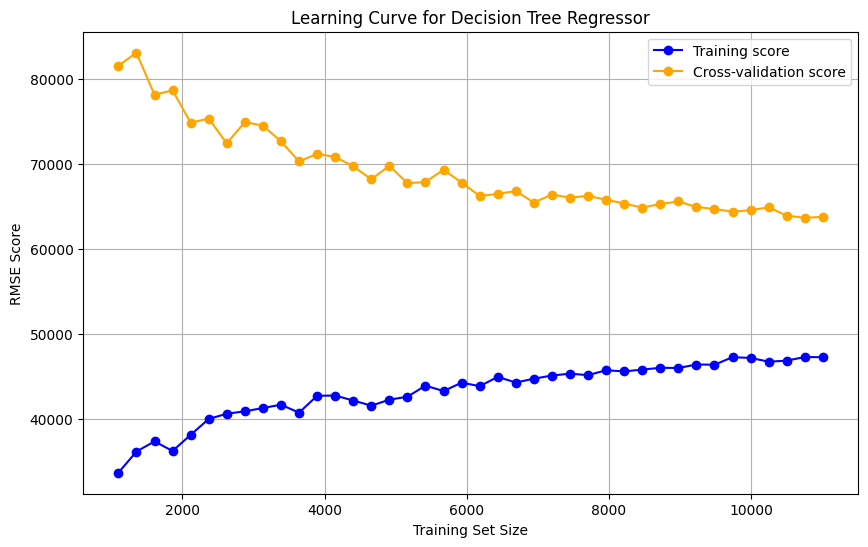

In [57]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Decision Tree Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid()
plt.show()

In [58]:
#Create RandomForestRegressor model
rnd_reg=make_pipeline(
    preprocessor,
    RandomForestRegressor(random_state=42)
)

#Tune the rnd_reg
param_dist_rf = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 5],
}

random_search_rf = RandomizedSearchCV(rnd_reg, param_distributions=param_dist_rf, cv=3, scoring='neg_root_mean_squared_error', n_iter=10, n_jobs=-1,verbose=1)
random_search_rf.fit(X_train, y_train)

print(f"Best score for RandomForestRegressor: { -random_search_rf.best_score_}")
print(f"Best params for RandomForestRegressor: { random_search_rf.best_params_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score for RandomForestRegressor: 50956.374263609
Best params for RandomForestRegressor: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': 30}


In [59]:
rnd_reg.set_params(**random_search_rf.best_params_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('log',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7d58515d5ea0>,
                                                                                       func=<function column_ratio at 0x7d58515d5c60>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['median_income',
                                                   'population'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=30, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=200,
                                       random_state=42))])

In [60]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rnd_reg, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 40)
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)


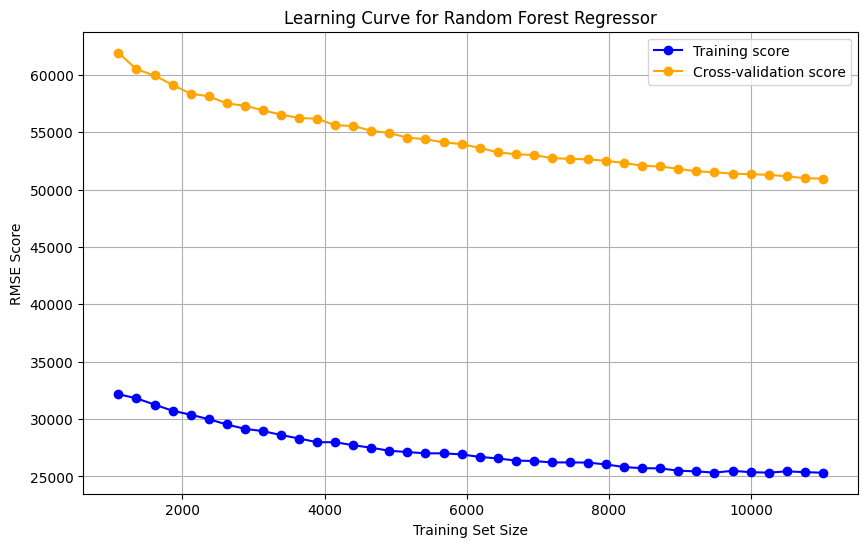

In [61]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Random Forest Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid()
plt.show()

<h3>Modle cross validation scores</h3>

In [62]:
#Modle score comparing

sgd_error=-cross_val_score(sgd_reg,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3).mean()
ridge_error=-cross_val_score(ridge_reg,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3).mean()
knn_error=-cross_val_score(knn_reg,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3).mean()
svr_error=-cross_val_score(svr_reg,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3).mean()
tree_error=-cross_val_score(dt_reg,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3).mean()
rnd_error=-cross_val_score(rnd_reg,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3).mean()

model_errors=pd.DataFrame({'SGDRegressor':sgd_error,
                          'Ridge':ridge_error,
                          'KNeighborsRegressor':knn_error,
                          'SVR':svr_error,
                          'DecisionTreeRegressor':tree_error,
                          'RandomForestRegressor':rnd_error},index=['errors'])

model_errors=model_errors.T
model_errors

,errors
SGDRegressor,73834.573683
Ridge,72456.501698
KNeighborsRegressor,64812.299459
SVR,105834.539184
DecisionTreeRegressor,63785.628082
RandomForestRegressor,50956.374264


- rnd_clf has the lowest error comparing to others so we choose that as the best model

<h4>use the rnd_model on the test data</h4>

In [63]:
rnd_reg.fit(X_train,y_train)

y_pred=rnd_reg.predict(X_test)


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
test_score=root_mean_squared_error(y_test,y_pred)
print(f"RMSE for rnd_reg on test data: {test_score}")

RMSE for rnd_reg on test data: 47394.570404124344
